In [1]:
import os
from os.path import isdir, join
from subprocess import check_output

import pandas as pd
import IPython.display as ipd

import seaborn as sns
import matplotlib.pyplot as plt


/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
valid = {}
for line in open("./data/validation_list.txt"):
    label, f = line.rstrip().split("/")
    if label not in valid:
        valid[label] = [f]
    else:
        valid[label].append(f)
len(valid.keys())

30

In [3]:
test = {}
for line in open("./data/testing_list.txt"):
    label, f = line.rstrip().split("/")
    if label not in test:
        test[label] = [f]
    else:
        test[label].append(f)
len(test.keys())

30

In [4]:
train_audio_path = 'data'
train_labels = os.listdir(train_audio_path)

wavs = [[],[],[]]
labels = [[],[],[]]
for label in train_labels:
    if label == '_background_noise_' or label == ".DS_Store":
        continue
    if os.path.isdir(train_audio_path + "/" + label):
        files = os.listdir(train_audio_path + '/' + label)
        for f in files:
            if not f.endswith('wav'):
                continue
            if f in valid[label]:
                wavs[1].append(f)
                labels[1].append(label)
            elif f in test[label]:
                wavs[2].append(f)
                labels[2].append(label)
            else:
                wavs[0].append(f)
                labels[0].append(label)

train_df = pd.DataFrame({'file':wavs[0],'label':labels[0]})
valid_df = pd.DataFrame({'file':wavs[1],'label':labels[1]})
test_df = pd.DataFrame({'file':wavs[2],'label':labels[2]})

In [5]:
train_df.describe(include="all")

,file,label
count,51088,51088
unique,5104,30
top,c0445658_nohash_0.wav,one
freq,30,1892


['right' 'eight' 'cat' 'tree' 'bed' 'happy' 'go' 'dog' 'no' 'wow' 'nine'
 'left' 'stop' 'three' 'sheila' 'one' 'bird' 'zero' 'seven' 'up' 'marvin'
 'two' 'house' 'down' 'six' 'yes' 'on' 'five' 'off' 'four']


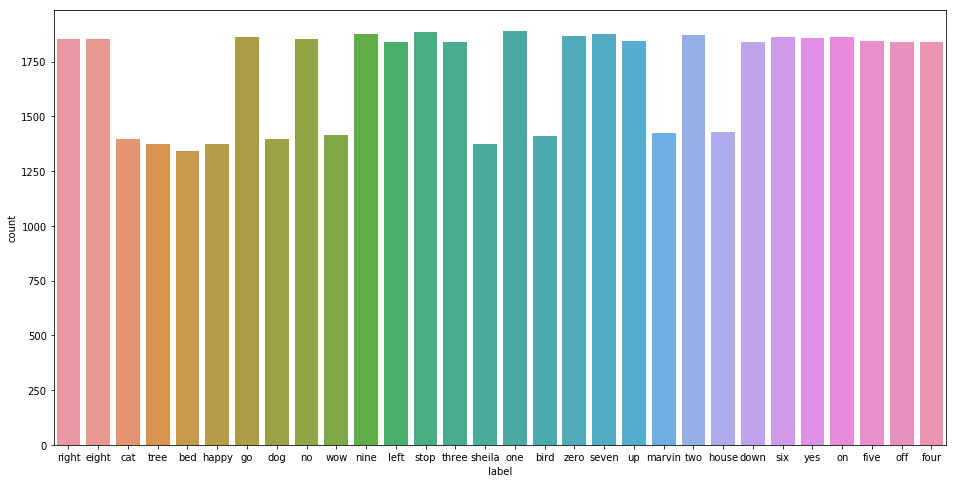

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(ax=ax, x="label", data=train_df)
print(train_df.label.unique())

In [7]:
valid_df.describe(include="all")

,file,label
count,6798,6798
unique,654,30
top,264f471d_nohash_0.wav,four
freq,30,280


['right' 'eight' 'cat' 'tree' 'bed' 'happy' 'go' 'dog' 'no' 'wow' 'nine'
 'left' 'stop' 'three' 'sheila' 'one' 'bird' 'zero' 'seven' 'up' 'marvin'
 'two' 'house' 'down' 'six' 'yes' 'on' 'five' 'off' 'four']


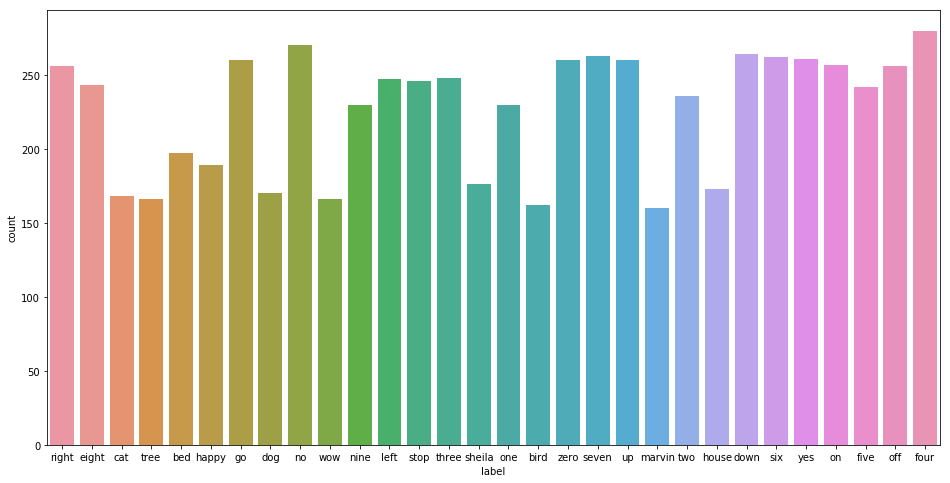

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(ax=ax, x="label", data=valid_df)
print(valid_df.label.unique())

In [9]:
test_df.describe(include="all")

,file,label
count,6835,6835
unique,654,30
top,d0faf7e4_nohash_0.wav,up
freq,30,272


['right' 'eight' 'cat' 'tree' 'bed' 'happy' 'go' 'dog' 'no' 'wow' 'nine'
 'left' 'stop' 'three' 'sheila' 'one' 'bird' 'zero' 'seven' 'up' 'marvin'
 'two' 'house' 'down' 'six' 'yes' 'on' 'five' 'off' 'four']


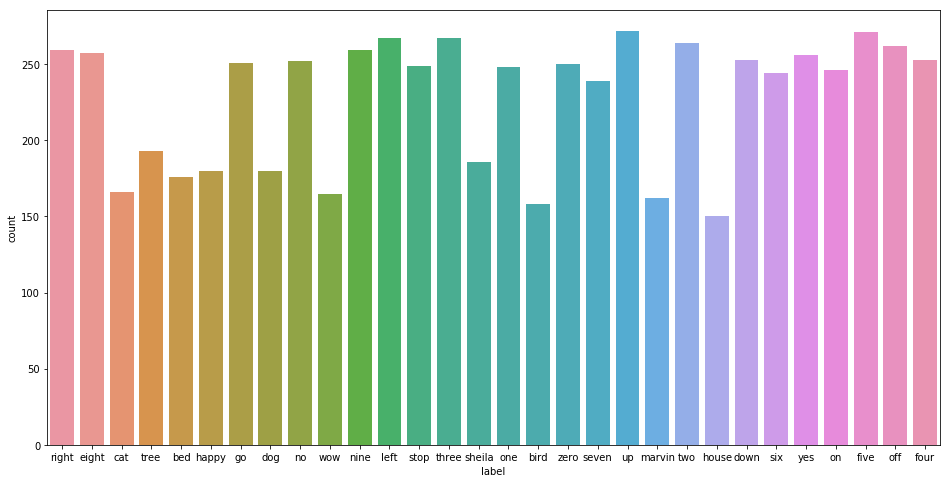

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(ax=ax, x="label", data=test_df)
print(test_df.label.unique())

In [11]:
train_df.to_csv("./data/train_list.csv")
valid_df.to_csv("./data/valid_list.csv")
test_df.to_csv("./data/test_list.csv")

## Listen to a sample

In [12]:
sample = train_df.sample(n=1)
print(sample.iloc[0]["label"])
print(sample.iloc[0]["file"])
ipd.Audio(filename="data/%s/%s" % 
                      (sample.iloc[0]["label"],
                       sample.iloc[0]["file"]))

house
afe0b87d_nohash_1.wav


In [13]:
sample = valid_df.sample(n=1)
print(sample.iloc[0]["label"])
print(sample.iloc[0]["file"])
ipd.Audio(filename="data/%s/%s" % 
                      (sample.iloc[0]["label"],
                       sample.iloc[0]["file"]))

eight
e54a0f16_nohash_1.wav


In [14]:
sample = test_df.sample(n=1)
print(sample.iloc[0]["label"])
print(sample.iloc[0]["file"])
ipd.Audio(filename="data/%s/%s" % 
                      (sample.iloc[0]["label"],
                       sample.iloc[0]["file"]))

tree
a591c2ea_nohash_0.wav


## Getting Spectogram

In [21]:
from scipy import signal
from scipy.io import wavfile
import numpy as np

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [16]:
# from https://www.kaggle.com/davids1992/speech-representation-and-data-exploration
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return (audio, sample_rate,
            freqs, times, 
            np.log(spec.T.astype(np.float32) + eps))

In [17]:
def get_log_specgram(_filename):
    sample_rate, samples = wavfile.read(_filename)
    return log_specgram(samples, sample_rate)

In [18]:
sample = train_df.sample(n=1)
print(sample.iloc[0]["label"])
print(sample.iloc[0]["file"])

filename = "data/%s/%s" % (sample.iloc[0]["label"],
                            sample.iloc[0]["file"])
ipd.Audio(filename=filename)

wow
8ff44869_nohash_2.wav


In [34]:
%time
samples, sample_rate, freqs, times, spectrogram = get_log_specgram(filename)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


Text(0.5,0,'Seconds')

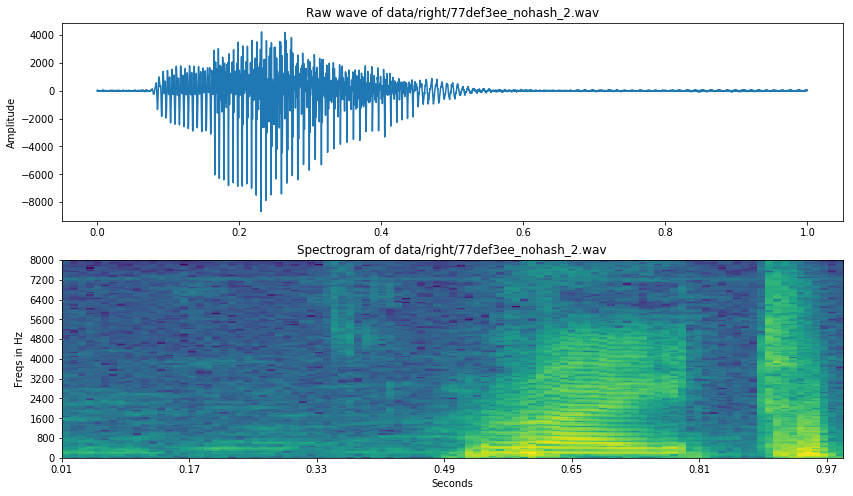

In [45]:

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [52]:
spectrogram.shape, len(freqs), len(times)

((99, 161), 161, 99)

** do zero padding work okay?

In [61]:
def extract_spectrogram_from_files(df):
    specs = []
    max_time = -1
    for i, row in df.iterrows():
        filename = "data/%s/%s" % (row["label"], row["file"])
        _, _, _, _, spectrogram = get_log_specgram(filename)

        specs.append(spectrogram)
        if len(times) > max_time:
            max_time = len(times)

    # padding
    for i in range(len(specs)):
        if len(specs[i]) < max_time:
            specs[i] = np.pad(specs[i], 
                              ((0,max_time - len(specs[i])),(0,0)), 
                              mode="constant", 
                              constant_values=0)
    return np.dstack(specs)   

In [63]:
%%time
valid_spec = extract_spectrogram_from_files(valid_df)
print(valid_spec.shape)

(99, 161, 6798)
CPU times: user 10.3 s, sys: 681 ms, total: 10.9 s
Wall time: 11 s


In [64]:
%%time
test_spec = extract_spectrogram_from_files(test_df)
print(test_spec.shape)

(99, 161, 6835)
CPU times: user 12 s, sys: 1.42 s, total: 13.4 s
Wall time: 16 s


In [65]:
%%time
train_spec = extract_spectrogram_from_files(train_df)
print(train_spec.shape)

(99, 161, 51088)
CPU times: user 1min 47s, sys: 19.7 s, total: 2min 7s
Wall time: 3min 15s


In [67]:
np.save("preprocessed/train_spec.npy",train_spec)

In [68]:
np.save("preprocessed/valid_spec.npy",valid_spec)

In [69]:
np.save("preprocessed/test_spec.npy",test_spec)

## Mel-scaled filter banks & MFCC

compare two libraries
1. python_speech_features (https://github.com/jameslyons/python_speech_features)
2. speechpy (https://github.com/astorfi/speechpy)

I removed librosa since the parameters are not easy to configure according to the papers (window length, window stride).

In [130]:
from python_speech_features import mfcc, logfbank, delta
from speechpy.feature import mfcc as mfcc2
from speechpy.feature import lmfe


In [120]:
def get_melfbank(_filename, n_filters=26):
    samplerate, samples = wavfile.read(_filename)
    return logfbank(samples.astype(float), samplerate=samplerate, 
                    nfilt=n_filters)

def get_mfcc(_filename):
    samplerate, samples = wavfile.read(_filename)
    return mfcc(samples.astype(float), samplerate=samplerate)

In [123]:
def get_melfbank2(_filename, n_filters=26):
    samplerate, samples = wavfile.read(_filename)
    return lmfe(samples.astype(float), sampling_frequency=samplerate, 
                num_filters=n_filters,
                frame_length=0.025,
                frame_stride=0.01)

def get_mfcc2(_filename):
    samplerate, samples = wavfile.read(_filename)
    return mfcc2(samples.astype(float), sampling_frequency=samplerate,
                num_filters=13,
                frame_length=0.025,
                frame_stride=0.01)

In [93]:
sample = train_df.sample(n=1)
print(sample.iloc[0]["label"])
print(sample.iloc[0]["file"])

filename = "data/%s/%s" % (sample.iloc[0]["label"],
                            sample.iloc[0]["file"])
ipd.Audio(filename=filename)

no
0819edb0_nohash_0.wav


In [109]:
%%timeit
mel = get_melfbank(filename, n_filters=40)

3.26 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
%%timeit
mel = get_melfbank2(filename, n_filters=40)

6 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [128]:
%%timeit
mfcc_result = get_mfcc(filename)

2.91 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
%%timeit
mfcc_result = get_mfcc2(filename)

2.89 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**python_speech_features is faster for computing mel filter bank and similar for mfcc**

## preprocess all the files

In [147]:
def get_mfcc(_filename):
    samplerate, samples = wavfile.read(_filename)
    results = mfcc(samples.astype(float), samplerate=samplerate)
    delta_results  = delta(results, 1)
    delta2_results = delta(results, 2)
    return np.concatenate([results, delta_results, delta2_results],axis=1)

In [148]:
mel = get_melfbank(filename, n_filters=40)
mel.shape

(99, 40)

In [163]:
def extract_mfcc_from_files(df):
    _mfcc = []
    max_time = -1
    for i, row in df.iterrows():
        filename = "data/%s/%s" % (row["label"], row["file"])
        result = get_mfcc(filename)
        _mfcc.append(result)
        if result.shape[0] > max_time:
            max_time = result.shape[0]
        
    # padding
    for i in range(len(_mfcc)):
        if _mfcc[i].shape[0] < max_time:
            _mfcc[i] = np.pad(_mfcc[i], 
                           ((0, max_time - _mfcc[i].shape[0]), (0,0)), 
                           mode="constant", 
                           constant_values=0)
    return np.dstack(_mfcc)

In [164]:
%%time
valid_mfcc = extract_mfcc_from_files(valid_df)

CPU times: user 2min 18s, sys: 39.4 s, total: 2min 57s
Wall time: 47 s


In [165]:
%%time
test_mfcc = extract_mfcc_from_files(test_df)

CPU times: user 2min 22s, sys: 42 s, total: 3min 4s
Wall time: 49.1 s


In [166]:
%%time
train_mfcc = extract_mfcc_from_files(train_df)

CPU times: user 17min 54s, sys: 5min 23s, total: 23min 18s
Wall time: 6min 27s


In [167]:
train_mfcc.shape, valid_mfcc.shape, test_mfcc.shape

((99, 39, 51088), (99, 39, 6798), (99, 39, 6835))

In [168]:
def extract_melfbank_from_files(df):
    _mfbank = []
    max_time = -1
    for i, row in df.iterrows():
        filename = "data/%s/%s" % (row["label"], row["file"])
        result = get_melfbank(filename, n_filters=40)
        _mfbank.append(result)
        if result.shape[0] > max_time:
            max_time = result.shape[0]
        
    # padding
    for i in range(len(_mfbank)):
        if _mfbank[i].shape[0] < max_time:
            _mfbank[i] = np.pad(_mfbank[i], 
                           ((0, max_time - _mfbank[i].shape[0]), (0,0)), 
                           mode="constant", 
                           constant_values=0)
    return np.dstack(_mfbank)

In [169]:
%%time
valid_mel = extract_melfbank_from_files(valid_df)

CPU times: user 1min 22s, sys: 24.1 s, total: 1min 47s
Wall time: 29.6 s


In [170]:
%%time
test_mel = extract_melfbank_from_files(test_df)

CPU times: user 1min 18s, sys: 21.3 s, total: 1min 39s
Wall time: 26.7 s


In [171]:
%%time
train_mel = extract_melfbank_from_files(train_df)

CPU times: user 10min 25s, sys: 3min 3s, total: 13min 28s
Wall time: 3min 50s


In [172]:
train_mel.shape, valid_mel.shape, test_mel.shape

((99, 40, 51088), (99, 40, 6798), (99, 40, 6835))

In [173]:
np.save("preprocessed/train_mel.npy", train_mel)
np.save("preprocessed/train_mfcc.npy", train_mfcc)

In [174]:
np.save("preprocessed/valid_mel.npy", valid_mel)
np.save("preprocessed/valid_mfcc.npy", valid_mfcc)

In [175]:
np.save("preprocessed/test_mel.npy", test_mel)
np.save("preprocessed/test_mfcc.npy", test_mfcc)